In [120]:
import pandas as pd
import tqdm
import networkx as nx
import datetime as dt
import matplotlib.pyplot as plt   
from sklearn.cluster import DBSCAN 
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import normalize 
from sklearn.decomposition import PCA
import numpy as np
from bokeh.plotting import figure, output_notebook, show #builds interactive graphs for python
from bokeh.models import Range1d
import math #this is used in graphic section to use the irrational number pi
output_notebook() #Allows inline plotting for Juptyer notebook

from bokeh.tile_providers import get_provider, Vendors
from pyproj import Transformer
tile_provider = get_provider('STAMEN_TERRAIN')

Loading BokehJS ...

In [3]:
data = pd.read_feather(os.getcwd() + '/metadata.feather', columns=['filename','datetime','lat','lon'])
data

,filename,datetime,lat,lon
0,meta-27PknKIOwHt6.json,2020-10-31 23:02:29,34.0724,-118.4026
1,meta-m3Wq53jjPnpw.json,2020-12-21 23:22:36,34.0473,-118.2599
2,meta-kpKT3stt5LXq.json,2020-12-04 20:49:20,26.3340,-80.2949
3,meta-qgU5924Q8jQh.json,2020-11-04 07:29:46,33.9827,-118.2094
4,meta-XfeRIAoVLtei.json,2020-07-02 12:50:02,-22.3546,-42.3357
...,...,...,...,...
68281,meta-JMfLmefCzvMW.json,2020-06-30 07:03:29,-35.2165,138.5386
68282,meta-33oluYHSIrDn.json,2020-07-17 09:44:45,33.8139,-117.5453
68283,meta-pMdvwJuktYPj.json,2020-12-12 19:53:48,38.8907,-77.0058
68284,meta-50A0Fl2Fcg89.json,2020-11-25 21:05:29,49.1741,-122.6799


In [13]:
# Filter to data from 6 Jan 2021
dday = data[(data.datetime > dt.datetime(2021,1,6,0,0,0)) & (data.datetime < dt.datetime(2021,1,7,0,0,0))]
dday

,filename,datetime,lat,lon
34,meta-8YA6CeYMxHh4.json,2021-01-06 17:07:48,38.8922,-77.0352
72,meta-91Vga2rHrrID.json,2021-01-06 13:03:23,38.8919,-77.0368
123,meta-a3NbAuIyNM3v.json,2021-01-06 16:52:51,0.0000,0.0000
153,meta-5QFPFJfJCo8U.json,2021-01-06 20:03:32,30.2374,-85.9145
199,meta-c5ovRK1TspWu.json,2021-01-06 13:24:08,39.6470,-75.7552
...,...,...,...,...
68099,meta-pmIbT1fHBBTK.json,2021-01-06 17:27:04,36.7512,-96.9243
68137,meta-TK5675UzIa2n.json,2021-01-06 18:18:48,38.8902,-77.0327
68177,meta-diIeD4Ne7Ear.json,2021-01-06 12:57:17,38.8918,-77.0362
68195,meta-q7BpcYyFpX7J.json,2021-01-06 21:29:07,38.8904,-77.0104


In [14]:
pplace = dday[(data.lat < 38.8930) & (data.lon > -77.0559) & (data.lat > 38.8812) & (data.lon < -76.9985)]
pplace

,filename,datetime,lat,lon
34,meta-8YA6CeYMxHh4.json,2021-01-06 17:07:48,38.8922,-77.0352
72,meta-91Vga2rHrrID.json,2021-01-06 13:03:23,38.8919,-77.0368
285,meta-mtR54fIOsU8Y.json,2021-01-06 06:41:44,38.8890,-77.0074
457,meta-kVSC3Z1yeZEe.json,2021-01-06 19:13:40,38.8912,-77.0114
477,meta-dltfIbXGM5gi.json,2021-01-06 21:04:29,38.8909,-77.0090
...,...,...,...,...
68093,meta-Ql2J5GJRtJVh.json,2021-01-06 15:00:26,38.8920,-77.0353
68137,meta-TK5675UzIa2n.json,2021-01-06 18:18:48,38.8902,-77.0327
68177,meta-diIeD4Ne7Ear.json,2021-01-06 12:57:17,38.8918,-77.0362
68195,meta-q7BpcYyFpX7J.json,2021-01-06 21:29:07,38.8904,-77.0104


In [36]:
base_time = dt.datetime(2021,1,6,0,0,0)
seconds = pplace.datetime.map(lambda x: (x - base_time).total_seconds())
pplace['seconds'] = seconds
pplace = pplace.reset_index()
pplace

,index,filename,datetime,lat,lon,seconds
0,34,meta-8YA6CeYMxHh4.json,2021-01-06 17:07:48,38.8922,-77.0352,61668.0
1,72,meta-91Vga2rHrrID.json,2021-01-06 13:03:23,38.8919,-77.0368,47003.0
2,285,meta-mtR54fIOsU8Y.json,2021-01-06 06:41:44,38.8890,-77.0074,24104.0
3,457,meta-kVSC3Z1yeZEe.json,2021-01-06 19:13:40,38.8912,-77.0114,69220.0
4,477,meta-dltfIbXGM5gi.json,2021-01-06 21:04:29,38.8909,-77.0090,75869.0
...,...,...,...,...,...,...
1074,68093,meta-Ql2J5GJRtJVh.json,2021-01-06 15:00:26,38.8920,-77.0353,54026.0
1075,68137,meta-TK5675UzIa2n.json,2021-01-06 18:18:48,38.8902,-77.0327,65928.0
1076,68177,meta-diIeD4Ne7Ear.json,2021-01-06 12:57:17,38.8918,-77.0362,46637.0
1077,68195,meta-q7BpcYyFpX7J.json,2021-01-06 21:29:07,38.8904,-77.0104,77347.0


In [38]:
points = pplace[['seconds', 'lat', 'lon']]
scaling = StandardScaler()
points_scaled = scaling.fit_transform(points)
points_normalized = normalize(points_scaled)
points_normalized = pd.DataFrame(points_normalized)
points_normalized

,0,1,2
0,-0.270705,0.727604,-0.630326
1,-0.732552,0.443017,-0.516821
2,-0.928940,-0.311072,0.200763
3,0.227478,0.670380,0.706289
4,0.708009,0.249798,0.660549
...,...,...,...
1074,-0.580329,0.577719,-0.573986
1075,-0.114239,-0.293776,-0.949023
1076,-0.755890,0.415262,-0.506150
1077,0.818358,-0.126607,0.560590


In [77]:
pca = PCA(n_components=2)
points_pca = pca.fit_transform(points_normalized)
points_pca = pd.DataFrame(points_pca)
points_pca.columns = ['p1', 'p2']
points_pca

,p1,p2
0,1.195372,-0.224097
1,1.168820,0.182846
2,0.339322,0.664634
3,-0.027441,-0.835504
4,-0.427856,-0.685998
...,...,...
1074,1.213359,0.021114
1075,0.822524,0.659724
1076,1.156884,0.212932
1077,-0.601366,-0.389611


In [79]:
cluster_model = DBSCAN(eps = 0.5, min_samples = 5).fit(points_pca)
labels = cluster_model.labels_

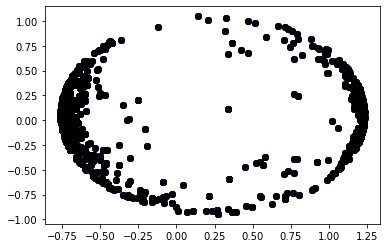

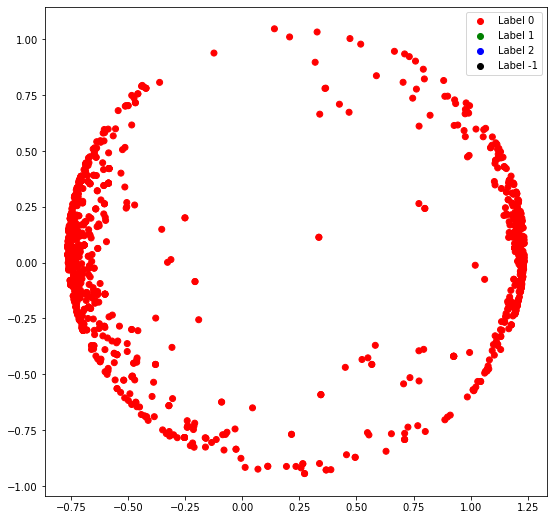

In [80]:
# Building the label to colour mapping 
colours = {} 
colours[0] = 'r'
colours[1] = 'g'
colours[2] = 'b'
colours[-1] = 'k'
  
# Building the colour vector for each data point 
cvec = [colours[label] for label in labels] 
  
# For the construction of the legend of the plot 
r = plt.scatter(points_pca['p1'], points_pca['p2'], color ='r'); 
g = plt.scatter(points_pca['p1'], points_pca['p2'], color ='g'); 
b = plt.scatter(points_pca['p1'], points_pca['p2'], color ='b'); 
k = plt.scatter(points_pca['p1'], points_pca['p2'], color ='k'); 
  
# Plotting P1 on the X-Axis and P2 on the Y-Axis  
# according to the colour vector defined 
plt.figure(figsize =(9, 9)) 
plt.scatter(points_pca['p1'], points_pca['p2'], c = cvec) 
  
# Building the legend 
plt.legend((r, g, b, k), ('Label 0', 'Label 1', 'Label 2', 'Label -1')) 
  
plt.show() 

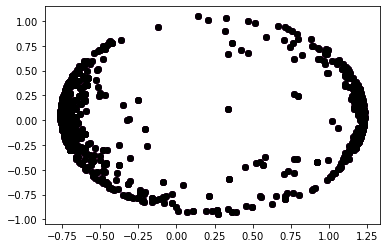

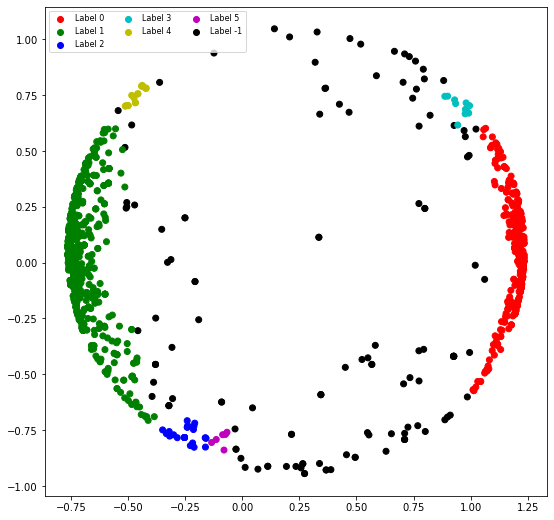

In [105]:
cluster = DBSCAN(eps=0.0675, min_samples=10).fit(points_pca)
labels_new = cluster.labels_ 

colours1 = {} 
colours1[0] = 'r'
colours1[1] = 'g'
colours1[2] = 'b'
colours1[3] = 'c'
colours1[4] = 'y'
colours1[5] = 'm'
colours1[-1] = 'k'
  
cvec = [colours1[label] for label in labels_new] 
colors = ['r', 'g', 'b', 'c', 'y', 'm', 'k' ] 
  
r = plt.scatter(points_pca['p1'], points_pca['p2'], marker ='o', color = colors[0]) 
g = plt.scatter(points_pca['p1'], points_pca['p2'], marker ='o', color = colors[1]) 
b = plt.scatter(points_pca['p1'], points_pca['p2'], marker ='o', color = colors[2]) 
c = plt.scatter(points_pca['p1'], points_pca['p2'], marker ='o', color = colors[3]) 
y = plt.scatter(points_pca['p1'], points_pca['p2'], marker ='o', color = colors[4]) 
m = plt.scatter(points_pca['p1'], points_pca['p2'], marker ='o', color = colors[5]) 
k = plt.scatter(points_pca['p1'], points_pca['p2'], marker ='o', color = colors[-1]) 
  
plt.figure(figsize =(9, 9)) 
plt.scatter(points_pca['p1'], points_pca['p2'], c = cvec) 
plt.legend((r, g, b, c, y, m, k), 
           ('Label 0', 'Label 1', 'Label 2', 'Label 3', 'Label 4', 
            'Label 5', 'Label -1'), 
           scatterpoints = 1, 
           loc ='upper left', 
           ncol = 3, 
           fontsize = 8) 
plt.show() 

In [114]:
core_samples_mask = np.zeros_like(cluster.labels_, dtype=bool)
core_samples_mask[cluster.core_sample_indices_] = True
labels = pd.DataFrame(cluster.labels_,columns=['Cluster ID'])
result = pd.concat((pplace,labels), axis=1)

In [115]:
result

,index,filename,datetime,lat,lon,seconds,Cluster ID
0,34,meta-8YA6CeYMxHh4.json,2021-01-06 17:07:48,38.8922,-77.0352,61668.0,0
1,72,meta-91Vga2rHrrID.json,2021-01-06 13:03:23,38.8919,-77.0368,47003.0,0
2,285,meta-mtR54fIOsU8Y.json,2021-01-06 06:41:44,38.8890,-77.0074,24104.0,-1
3,457,meta-kVSC3Z1yeZEe.json,2021-01-06 19:13:40,38.8912,-77.0114,69220.0,-1
4,477,meta-dltfIbXGM5gi.json,2021-01-06 21:04:29,38.8909,-77.0090,75869.0,1
...,...,...,...,...,...,...,...
1074,68093,meta-Ql2J5GJRtJVh.json,2021-01-06 15:00:26,38.8920,-77.0353,54026.0,0
1075,68137,meta-TK5675UzIa2n.json,2021-01-06 18:18:48,38.8902,-77.0327,65928.0,-1
1076,68177,meta-diIeD4Ne7Ear.json,2021-01-06 12:57:17,38.8918,-77.0362,46637.0,0
1077,68195,meta-q7BpcYyFpX7J.json,2021-01-06 21:29:07,38.8904,-77.0104,77347.0,1


In [117]:
c0 = result[result['Cluster ID'] == 0]


In [118]:
#looks like all these points are well West of the Capitol.  Wondering if this is the rally/march?
print(c0.min(axis=0))
print(c0.max(axis=0))

index                             34
filename      meta-04aPSGXs9uu1.json
datetime         2021-01-06 12:22:20
lat                          38.8905
lon                          -77.053
seconds                        44540
Cluster ID                         0
dtype: object
index                          68177
filename      meta-zq269gxmbYsI.json
datetime         2021-01-06 18:48:41
lat                          38.8928
lon                         -77.0249
seconds                        67721
Cluster ID                         0
dtype: object


In [126]:
#This is definitely at the Capitol. From 6pm though; maybe I should redefine the bounds to just the insurrection?
c1 = result[result['Cluster ID'] == 1]
print(c1.min(axis=0))
print(c1.max(axis=0))
c1

index                            477
filename      meta-0261f0TEn46K.json
datetime         2021-01-06 18:01:54
lat                          38.8883
lon                         -77.0147
seconds                        64914
Cluster ID                         1
dtype: object
index                          68245
filename      meta-zql90aBoc1tJ.json
datetime         2021-01-06 23:23:58
lat                          38.8909
lon                         -77.0058
seconds                        84238
Cluster ID                         1
dtype: object


,index,filename,datetime,lat,lon,seconds,Cluster ID
4,477,meta-dltfIbXGM5gi.json,2021-01-06 21:04:29,38.8909,-77.0090,75869.0,1
5,606,meta-riReyNCVV3dd.json,2021-01-06 20:43:57,38.8900,-77.0099,74637.0,1
6,718,meta-QsKjvIGPfWKU.json,2021-01-06 19:53:53,38.8896,-77.0098,71633.0,1
7,765,meta-5kf2savkefB7.json,2021-01-06 19:36:20,38.8898,-77.0085,70580.0,1
8,767,meta-X9301RyNxl2u.json,2021-01-06 19:41:31,38.8904,-77.0103,70891.0,1
...,...,...,...,...,...,...,...
1070,67779,meta-e1gcuShcWxYz.json,2021-01-06 20:17:20,38.8901,-77.0099,73040.0,1
1072,67885,meta-TNi4F73rBo86.json,2021-01-06 20:35:23,38.8899,-77.0104,74123.0,1
1073,67938,meta-ScT8XU9t70YC.json,2021-01-06 18:19:23,38.8900,-77.0103,65963.0,1
1077,68195,meta-q7BpcYyFpX7J.json,2021-01-06 21:29:07,38.8904,-77.0104,77347.0,1
